# WGAN for image blending in TensorFlow

Lots from here: https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html


As described in paper: Gp-gan: Towards realistic high-resolution image blending

In [195]:
import os
COCO_API_DIR = 'D:/Datasets/COCO/cocoapi-master/PythonAPI'
COCO_ROOT = 'D:/Datasets/COCO/'
COCO_SET = 'train2017'
import sys
sys.path.append('../frontend')
sys.path.append('../backend')
sys.path.append(COCO_API_DIR)
import tensorflow as tf
import tensorflow.contrib as tc
from threading import Thread
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
import cv2
import glob
import time
from keras.layers import *
import keras
import pickle
from keras.models import *
from IPython.display import clear_output
import keras.backend as K
import keras.optimizers
import datasets
import composition
from pycocotools.coco import COCO

In [336]:
def conv2d(input, numkernels, kernel_size=[3,3], strides=[1,1,1,1],stddev=0.001,name='conv2d', weights_dict=None):
    with tf.variable_scope(name):
        
        w = None
        b = None
        if weights_dict is not None:
            for k in weights_dict.keys():
                if( name + '/weights' in k ):
                    print('Loaded weight from provided dict for layer: {}'.format(k))
                    w = tf.get_variable('weights', kernel_size+[ input.get_shape()[-1], numkernels ], initializer=tf.constant_initializer( weights_dict[k] ))
                if( name + '/biases' in k ):
                    print('Loaded biases from provided dict for layer: {}'.format(k))
                    b = tf.get_variable('biases', [numkernels], initializer=tf.constant_initializer( weights_dict[k] ))
                        
        if w is None:
            w = tf.get_variable('weights', kernel_size+[ input.get_shape()[-1], numkernels ], initializer=tf.truncated_normal_initializer(stddev=stddev))
        if b is None:
            b = tf.get_variable('biases', [numkernels], initializer=tf.zeros_initializer())
        
        conv = tf.nn.bias_add(tf.nn.conv2d(input, w, strides, padding='SAME'), b)
        return conv

def deconv2d(input, numkernels, output_size, kernel_size=[3,3], strides=[1,2,2,1], stddev=0.001, name='deconv2d', weights_dict=None):
    with tf.variable_scope(name):
        w = None
        b = None
        if weights_dict is not None:
            for k in weights_dict.keys():
                if( name + '/weights' in k ):
                    print('Loaded weight from provided dict for layer: {}'.format(k))
                    w = tf.get_variable('weights', kernel_size + [ numkernels, input.get_shape()[-1] ], initializer=tf.constant_initializer( weights_dict[k] ))
                if( name + '/biases' in k ):
                    print('Loaded biases from provided dict for layer: {}'.format(k))
                    b = tf.get_variable('biases', [numkernels], initializer=tf.constant_initializer( weights_dict[k] ))
        
        
        
        if w is None:
            w = tf.get_variable('weights', kernel_size + [ numkernels, input.get_shape()[-1] ], initializer=tf.truncated_normal_initializer(stddev=stddev))
        if b is None:
            b = tf.get_variable('biases', [numkernels], initializer=tf.zeros_initializer())
        deconv = tf.nn.bias_add(tf.nn.conv2d_transpose(input, w, output_shape=[ int(input.get_shape()[0]), output_size[0], output_size[1], numkernels ], strides=strides, padding='SAME'), b)
        return deconv
    
class CWGAN:
    
    
    def __init__(self, batch_size=4, real_dim=[64,64,3], z_dim=[64,64,3], y_dim=[64,64,3], weights_dict=None):
        self.batch_size = batch_size
        self.z_dim = z_dim
        self.real_dim = real_dim
        self.weights_dict= weights_dict
    
        
    def build_model(self):
        self.z = tf.placeholder(tf.float32, [None] + self.z_dim, name='gen_input')
        self.images_real = tf.placeholder(tf.float32, [None] + self.real_dim, name='images_real')
        self.images_fake = tf.placeholder(tf.float32, [None] + self.real_dim, name='images_fake')
        
        self.G = self.generator(self.z, weights_dict=self.weights_dict)
        self.D_real, self.D_real_logits = self.discriminator( self.images_real, reuse=False, weights_dict=self.weights_dict)
        self.D_fake, self.D_fake_logits = self.discriminator( self.G, reuse=True, weights_dict=self.weights_dict )
        self.D_fake2, self.D_fake_logits2 = self.discriminator( self.images_fake, reuse=True, weights_dict=self.weights_dict )
        
        # Define the loss
        self.d_loss_real = tf.reduce_mean( self.D_real_logits )
        self.d_loss_fake = tf.reduce_mean( self.D_fake_logits )
        self.d_loss = tf.reduce_mean( self.D_fake_logits ) - tf.reduce_mean( self.D_real_logits )
        
        self.d_loss2 = tf.reduce_mean( self.D_fake_logits2 ) - tf.reduce_mean( self.D_real_logits )
        
        
        # AE loss
        self.ae_loss = tf.reduce_mean( tf.abs(self.G-self.z)  ) + tf.reduce_mean( tf.pow( self.G-self.z ,2) )
        
        self.g_loss = -tf.reduce_mean( self.D_fake_logits ) 
        
        # Regularizer
#        self.reg = tc.layers.apply_regularization(tc.layers.l1_regularizer(0.1), weights_list=[ var for var in tf.global_variables() if 'weights' in var.name ])
#        self.g_loss += self.reg
 #       self.d_loss += self.reg
        
        
        t_vars = tf.trainable_variables()
        self.d_vars = [ var for var in t_vars if 'd_' in var.name ]
        self.g_vars = [ var for var in t_vars if 'g_' in var.name ]

        self.saver = tf.train.Saver()
        
    def discriminator(self, images, leak=0.2, reuse=False, weights_dict=None):
        with tf.variable_scope('discriminator') as scope:
            if(reuse):
                scope.reuse_variables()
            h0 = images
            h1 = tf.nn.leaky_relu( conv2d(h0, 32, kernel_size=[3,3], strides=[1,2,2,1], name='d_h1', weights_dict=weights_dict), alpha=leak, name='d_h1_act' )
            h2 = tf.nn.leaky_relu( conv2d(h1, 64, kernel_size=[3,3], strides=[1,2,2,1], name='d_h2', weights_dict=weights_dict), alpha=leak, name='d_h2_act' )
            h3 = tf.nn.leaky_relu( conv2d(h2, 128, kernel_size=[3,3], strides=[1,2,2,1], name='d_h3', weights_dict=weights_dict), alpha=leak, name='d_h3_act' )
            h4 = tf.nn.leaky_relu( conv2d(h3, 256, kernel_size=[3,3], strides=[1,2,2,1], name='d_h4', weights_dict=weights_dict), alpha=leak, name='d_h4_act' )
            h5 = tf.nn.leaky_relu( conv2d(h4, 512, kernel_size=[3,3], strides=[1,2,2,1], name='d_h5', weights_dict=weights_dict), alpha=leak, name='d_h5_act' )
            h6_logits = tf.reshape(conv2d(h5, 1, kernel_size=[2,2], strides=[1,2,2,1], name='d_h6', weights_dict=weights_dict), [-1, 1], name='d_logits')
            h6 = tf.nn.sigmoid( h6_logits, name='probs' )
            return h6, h6_logits
    
    def generator(self, z, leak=0.2, weights_dict=None):
        with tf.variable_scope('generator') as scope:

            # Get the sizes right
            size0 = [ int(z.get_shape()[1]), int(z.get_shape()[2]) ]
            size1 = [ int(p//2) for p in size0 ]
            size2 = [ int(p//2) for p in size1 ]
            size3 = [ int(p//2) for p in size2 ]
            size4 = [ int(p//2) for p in size3 ]
            
            # Downsampling parts
            ds0 = z
            ds1 = tf.nn.leaky_relu(conv2d(ds0, 32, strides=[1,2,2,1], name='g_ds1', weights_dict=weights_dict), alpha=leak, name='g_ds1_act')
            ds2 = tf.nn.leaky_relu(conv2d(ds1, 64, strides=[1,2,2,1], name='g_ds2', weights_dict=weights_dict), alpha=leak, name='g_ds2_act')
            ds3 = tf.nn.leaky_relu(conv2d(ds2, 128, strides=[1,2,2,1], name='g_ds3', weights_dict=weights_dict), alpha=leak, name='g_ds3_act')
            ds4 = tf.nn.leaky_relu(conv2d(ds3, 256, strides=[1,2,2,1], name='g_ds4', weights_dict=weights_dict), alpha=leak, name='g_ds4_act')
            ds5 = tf.nn.leaky_relu(conv2d(ds4, 512, strides=[1,2,2,1], name='g_ds5', weights_dict=weights_dict), alpha=leak, name='g_ds5_act')

            # Reshaping to make sure we have proper upsampling
            ds5_shape = ds5.get_shape()
            ds5 = tf.reshape(ds5, [ self.batch_size, ds5_shape[1], ds5_shape[2], ds5_shape[3] ])
            
            # Upsampling blocks
            us4 = tf.nn.leaky_relu(deconv2d(ds5, 512, output_size=size4, name='g_us4', weights_dict=weights_dict), alpha=leak, name='g_us4_act')
            r4 = tf.concat([ ds4, us4 ], axis=3, name='r4')
            us3 = tf.nn.leaky_relu(deconv2d(r4, 256, output_size=size3, name='g_us3', weights_dict=weights_dict), alpha=leak, name='g_us3_act')
            r3 = tf.concat([ ds3, us3 ], axis=3, name='r3')
            us2 = tf.nn.leaky_relu(deconv2d(r3, 128, output_size=size2, name='g_us2', weights_dict=weights_dict), alpha=leak, name='g_us2_act')
            r2 = tf.concat([ ds2, us2 ], axis=3, name='r2')
            us1 = tf.nn.leaky_relu(deconv2d(r2, 64, output_size=size1, name='g_us1', weights_dict=weights_dict), alpha=leak, name='g_us1_act')
            r1 = tf.concat([ ds1, us1 ], axis=3, name='r1')
            us0 = tf.nn.leaky_relu(deconv2d(r1, 32, output_size=size0, name='g_us0', weights_dict=weights_dict), alpha=leak, name='g_us0_act')
            r0 = tf.concat( [ ds0, us0 ], axis=3, name='r0' )

            out = conv2d(r0, 3, strides=[1,1,1,1], name='g_out', weights_dict=weights_dict)
            return out

    def get_weights(self, sess):
        weights=dict()
        for var in self.d_vars:
            weights[var.name] = var.eval()
        for var in self.g_vars:
            weights[var.name] = var.eval()
        return weights
        





In [337]:
def plot_progress(progress:list, past:int=1000, show:bool=True):
    p = np.array(progress)
    p = p[ np.max([0, p.shape[0]-past]): ]
    plt.plot(p[:,0], p[:,1])
    plt.plot(p[:,0], p[:,2])
    plt.plot(p[:,0], p[:,3])
    plt.grid()
    plt.legend(['d_loss: {}'.format(p[-1,1]), 'g_loss: {}'.format(p[-1,2]), 'ae_loss: {}'.format(p[-1,3])])
    plt.title('Progress for the last {} iterations'.format(past))
    if show:
        plt.show()

In [278]:
fake_cache = dict()

In [288]:
fake_fpaths = glob.glob('D:/Research/LayeredEmbeddings/val_set/*_full.pickle')


TypeError: get_weights() missing 1 required positional argument: 'sess'

Saving weights
-0.083298445
2.0167608e-06


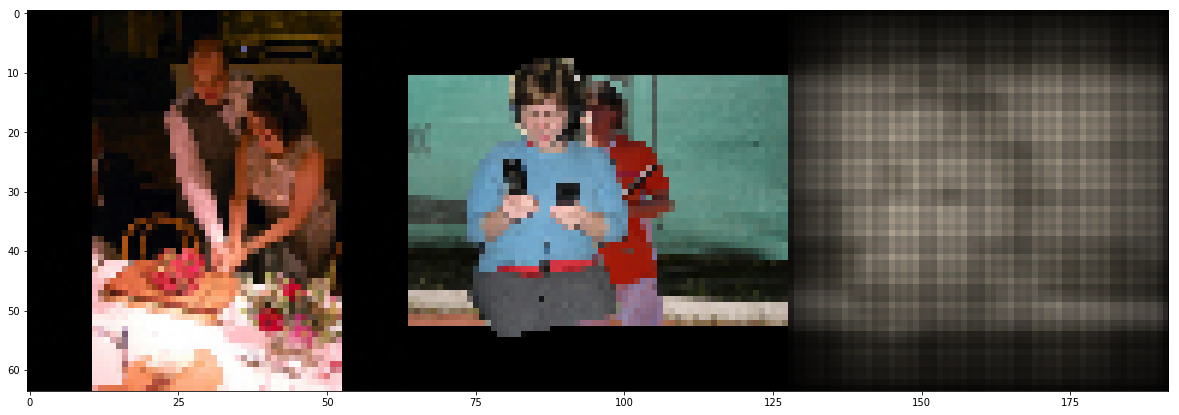

G pred: 0.007298797369003296 - 0.7649409174919128


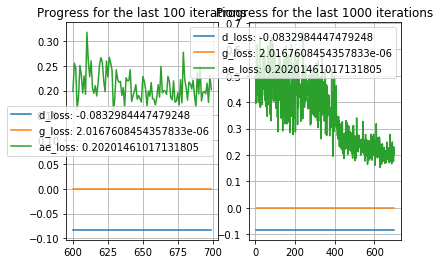

Starting the real examples threadStarting the fake examples thread

Loading from cache D:/Research/LayeredEmbeddings/val_set\example_000000362520_and_000000362716_full.pickle
Loading from cache D:/Research/LayeredEmbeddings/val_set\example_000000462031_and_000000463174_full.pickle
Loading from cache D:/Research/LayeredEmbeddings/val_set\example_000000128654_and_000000130579_full.pickle
Loading from cache D:/Research/LayeredEmbeddings/val_set\example_000000311394_and_000000302536_full.pickle
Fake examples done
Real examples done
Starting the real examples threadStarting the fake examples thread

Loading from cache D:/Research/LayeredEmbeddings/val_set\example_000000400815_and_000000401244_full.pickle
Loading from cache D:/Research/LayeredEmbeddings/val_set\example_000000554328_and_000000554156_full.pickle
Loading from cache D:/Research/LayeredEmbeddings/val_set\example_000000347174_and_000000345252_full.pickle
Loading from cache D:/Research/LayeredEmbeddings/val_set\example_000000463174

In [ ]:
batch_size = 4
tf.reset_default_graph()
wgan = CWGAN(weights_dict=weights, batch_size=batch_size)
#wgan = CWGAN(batch_size=batch_size)
wgan.build_model()
it = 0
progress = []
provideNewExamples = True

with tf.Session() as sess:


    d_optim = tf.train.AdamOptimizer(0.0001, beta1=0.5, beta2=0.9).minimize( wgan.d_loss, var_list=wgan.d_vars )
    d_optim2 = tf.train.AdamOptimizer(0.0001, beta1=0.5, beta2=0.9).minimize( wgan.d_loss2, var_list=wgan.d_vars )
    g_optim = tf.train.AdamOptimizer(0.0001, beta1=0.5, beta2=0.9).minimize( wgan.g_loss, var_list=wgan.g_vars )
    ae_optim = tf.train.AdamOptimizer(0.00001, beta1=0.5, beta2=0.9).minimize( wgan.ae_loss, var_list=wgan.g_vars )

    d_clip = tf.group(*[v.assign(tf.clip_by_value(
        v, -0.01, 0.01)) for v in wgan.d_vars])
    
    sess.run( tf.global_variables_initializer() )

#    images_real = np.random.uniform(0,1,(4, 64,64,3))
#    images_comp = np.random.uniform(0,1,(4,64,64,3))

    while True:
        
        if provideNewExamples:
            list_real = list()
            list_fake = list()
            thread_real = Thread(target=get_real_examples, args=(list_real, coco, coco_kps, COCO_ROOT, imgIds, catIds, composition_params, batch_size))
            thread_fake = Thread(target=get_fake_examples_from_val, args=(list_fake, fake_cache, fake_fpaths, coco, coco_kps, COCO_ROOT, imgIds, catIds, composition_params, batch_size))
            thread_real.start()
            thread_fake.start()
        
        if it > 0:
            # DIS  on generated
#            _, d_loss_cur = sess.run( [d_optim, wgan.d_loss], feed_dict={ wgan.images_real:images_real/255, wgan.z:images_comp/255  } )
#            sess.run(d_clip)


            # DIS ON TRUE FAKE
            _, d_loss_cur2 = sess.run( [d_optim2, wgan.d_loss2], feed_dict={ wgan.images_real:images_real/255, wgan.images_fake:images_comp/255  } )
            sess.run(d_clip)
            
            # GENERATOR 
            _,_, g_loss_cur, ae_loss_cur = sess.run([ g_optim,ae_optim, wgan.g_loss, wgan.ae_loss ], feed_dict={ wgan.z:images_comp/255 })
            progress.append([ it, d_loss_cur, g_loss_cur, ae_loss_cur ])

        if provideNewExamples:
            thread_real.join()
            thread_fake.join()
            examples_real = np.array(list_real)
            examples_fake = np.array(list_fake)
            images_real = np.stack( [ cv2.resize(examples_real[i]['image_scaled_and_padded'], (64,64)) for i in range(0,batch_size)], axis=0 )
            # add some noise to real images
            images_real += np.random.normal(0, 1, size=images_real.shape);
            images_real = np.clip(images_real, 0, 255);
            images_comp = np.stack( [ cv2.resize(examples_fake[i]['image_scaled_and_padded'], (64,64)) for i in range(0,batch_size)], axis=0 )
            images_comp = np.clip(images_comp, 0, 255)
        
        it = it+1

        if(it % 10 == 0):
            clear_output() 

            weights = wgan.get_weights(sess)
            with open('wgan_weights', 'wb') as file:
                print('Saving weights')
                pickle.dump(weights, file)

            
            net_input = images_comp/255
            net_output = sess.run( wgan.G, feed_dict={wgan.z: net_input} )
            
            print(d_loss_cur)
            print(g_loss_cur)
            plt.figure(figsize=(21,7))
            plt.imshow( np.concatenate([ images_real[0].astype(np.uint8), 255*net_input[0], 255*net_output[0]  ], 1).astype(np.uint8))
            plt.show()
            print('G pred: {} - {}'.format(np.min(net_output), np.max(net_output)))
            
            plt.subplot(1,2,1)
            plot_progress(progress, past=100, show=False)
            plt.subplot(1,2,2)
            plot_progress(progress, past=1000, show=True)


In [302]:
print(images_real.shape)

(8, 64, 64, 3)


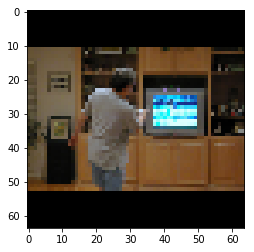

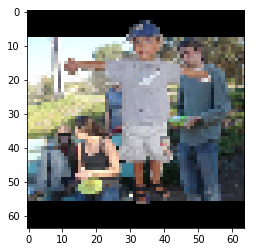

{'B': {'timing_sampling': 0.10299968719482422, 'image_scaled_and_padded': array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]]), 'img_info': {'flickr_url': 'ht

In [30]:
images_real = np.stack( [ cv2.resize(examples_real[i]['image_scaled_and_padded'], (64,64)) for i in range(0,batch_size)], axis=0 )
images_comp = np.stack( [ cv2.resize(examples_fake[i]['image_scaled_and_padded'], (64,64)) for i in range(0,batch_size)], axis=0 )

plt.imshow(images_real[2].astype(np.uint8))
plt.show()
plt.imshow(images_comp[2].astype(np.uint8))
plt.show()

print(examples_fake[0])


In [12]:
annFile='{}/annotations/instances_{}.json'.format(COCO_ROOT,COCO_SET)
annFileKPS = '{}/annotations/person_keypoints_{}.json'.format(COCO_ROOT,COCO_SET)
catNms = ['person']
coco=COCO(annFile)
coco_kps=COCO(annFileKPS)  
catIds = coco.getCatIds(catNms)
imgIds = coco.getImgIds(catIds=catIds )

loading annotations into memory...
Done (t=31.59s)
creating index...
index created!
loading annotations into memory...
Done (t=15.10s)
creating index...
index created!


In [290]:
def get_real_examples(list_out, coco, coco_kps, coco_root, imgIds, catIds, params, batch_size):
    print('Starting the real examples thread')
    # GET REFERENCE, NATURAL LOOKING EXAMPLES
    for i in range(0, batch_size):
        IM = composition.get_image_suitable_for_blending_with_meta(coco, coco_kps, coco_root, imgIds, catIds, longer_edge_size=params['longer_edge_size'], scale_range=params['scale_range_A'], shift_range=params['shift_range_A'], rot_range=params['rot_range_A'], allow_overlaps=params['allow_overlaps_in_A'])
        list_out.append(IM)
    print('Real examples done')

def get_fake_examples_from_val(list_out, fake_cache, fpaths, coco, coco_kps, coco_root, imgIds, catIds, params, batch_size):
    print('Starting the fake examples thread')
    # GET GENERATED EXAMPLES
    random.shuffle(fpaths)
    for i in range(0, batch_size):
        
        if fpaths[i] in fake_cache.keys():
            print('Loading from cache {}'.format(fpaths[i]))
            example = fake_cache[fpaths[i]]
        else:
            with open(fpaths[i], 'rb') as file:
                example = pickle.load(file)
                print('Adding to cache {}'.format(fpaths[i]))
                fake_cache[ fpaths[i] ] = example
        list_out.append(example)
    print('Fake examples done')
    
    
def get_fake_examples(list_out, coco, coco_kps, coco_root, imgIds, catIds, params, batch_size):
    print('Starting the fake examples thread')
    # GET GENERATED EXAMPLES
    for i in range(0, batch_size):
        while True:
            data_train = composition.get_composition(coco, coco_kps,coco_root, imgIds, catIds, params=params)
            if data_train is not None:
                list_out.append(data_train)
                break
    print('Fake examples done')
    

def get_training_examples(coco, coco_kps, coco_root, imgIds, catIds, composition_params, batch_size):
    
    list_real = list()
    list_fake = list()
    thread_real = Thread(target=get_real_examples, args=(list_real, coco, coco_kps, coco_root, imgIds, catIds, composition_params, batch_size))
    thread_fake = Thread(target=get_fake_examples, args=(list_fake, coco, coco_kps, coco_root, imgIds, catIds, composition_params, batch_size))
    
    thread_real.start()
    thread_fake.start()

    thread_real.join()
    thread_fake.join()
    return np.array(list_real), np.array(list_fake)

def trim_weights(model):
    for l in model.layers:
        w = l.get_weights()
        if len(w) > 0:
            print(w[0].shape)
            weights = np.clip(w[0], -0.01, 0.01)
            l.set_weights([ weights, w[1] ])


In [281]:
a = dict()

if 'a' in a.keys():
    print('yay')

In [16]:
composition_params = composition.default_composition_params
composition_params['longer_edge_size'] = 256
composition_params['allow_overlaps_in_A'] = True
composition_params['allow_overlaps_in_B'] = True
composition_params['max_occ_perc_th'] = 0.99
composition_params['overlap_perc_th'] = 0.99
batch_size = 4

In [17]:
list_real = list()
list_fake = list()
thread_real = Thread(target=get_real_examples, args=(list_real, coco, coco_kps, COCO_ROOT, imgIds, catIds, composition_params, batch_size))
thread_fake = Thread(target=get_fake_examples, args=(list_fake, coco, coco_kps, COCO_ROOT, imgIds, catIds, composition_params, batch_size))

thread_real.start()
thread_fake.start()




thread_real.join()
thread_fake.join()
examples_real = np.array(list_real)
examples_fake = np.array(list_fake)

Starting the fake examples threadStarting the real examples thread

Real examples done
Fake examples done


In [ ]:


while True:

    try:

        # Set up the threads to work in the background while running GPU tasks
        list_real = list()
        list_fake = list()
        thread_real = Thread(target=get_real_examples, args=(list_real, coco, coco_kps, COCO_ROOT, imgIds, catIds, composition_params, batch_size))
        thread_fake = Thread(target=get_fake_examples, args=(list_fake, coco, coco_kps, COCO_ROOT, imgIds, catIds, composition_params, batch_size))

        thread_real.start()
        thread_fake.start()

        if it > 0:
            if 0:
                plt.imshow( examples_real[0]['image_scaled_and_padded'].astype(np.uint8) )
                plt.show()
                plt.imshow( examples_real[0]['image_scaled_and_padded'].astype(np.uint8) )
                plt.show()

                plt.imshow( examples_fake[0]['image_scaled_and_padded'].astype(np.uint8) )
                plt.show()
                plt.imshow( examples_fake[0]['A']['rect_scaled_and_padded'].astype(np.uint8) )
                plt.show()
                plt.imshow( examples_fake[0]['inserted_mask'].astype(np.uint8) )
                plt.show()


            # CREATE BATCH FOR REAL VS FAKE FOR DISCRIMINATOR
            batch_real_x = np.zeros((batch_size//2, 64,64,3))
            batch_real_y = np.ones((batch_size//2, 1))
            batch_fake_x_in = np.zeros((batch_size//2, 64,64,3))
            batch_fake_y = np.zeros((batch_size//2, 1))
            for i in range(0, batch_size//2):
                batch_real_x[i] = cv2.resize( examples_real[i]['image_scaled_and_padded'], (64,64) )
                batch_fake_x_in[i] = cv2.resize( np.multiply(examples_fake[i]['image_scaled_and_padded'], np.expand_dims(examples_fake[i]['A']['rect_scaled_and_padded'],2)), (64,64) )
            batch_fake_x_out = gen_model.predict(batch_fake_x_in)
            dis_batch_x = np.concatenate([ batch_real_x,batch_fake_x_out ],0)
            dis_batch_y = np.concatenate([ batch_real_y,batch_fake_y ],0)


            dis_model.trainable = True
            dis_loss_cur = dis_model.train_on_batch(dis_batch_x, dis_batch_y)
            trim_weights(dis_model)
            print('Dis loss cur: {}'.format(dis_loss_cur))

            # CREATE BATCH FOR GENERATOR 
            batch_fake_x = np.zeros((batch_size, 64,64,3))
            for i in range(0, batch_size//2):
                batch_fake_x[i] = cv2.resize( np.multiply(examples_fake[i]['image_scaled_and_padded'], np.expand_dims(examples_fake[i]['A']['rect_scaled_and_padded'],2)), (64,64) )
            gen_loss_cur = gen_model.train_on_batch(batch_fake_x, batch_fake_x)
            print('Gen loss cur: {}'.format(gen_loss_cur))


            # GAN TRAINING IN FULL
            dis_model.trainable = False
            gan_loss_cur = gan_model.train_on_batch( batch_fake_x, np.ones((batch_size,1)) )
            print('GAN loss cur: {}'.format(gan_loss_cur))

            progress.append([ it, dis_loss_cur,  gen_loss_cur, gan_loss_cur ])

        # Wait for the threads to stop and store new training data
        thread_real.join()
        thread_fake.join()
        examples_real = np.array(list_real)
        examples_fake = np.array(list_fake)

        it += 1

        if it % 4 == 0:
            clear_output()
            print('It: {}, DIS loss: {}, GEN loss: {}, GAN loss: {}'.format(it, dis_loss_cur, gen_loss_cur, gan_loss_cur))

            plt.subplot(1,2,1)
            plt.imshow(batch_fake_x_in[0].astype(np.uint8))
            plt.title('Before')
            plt.subplot(1,2,2)
            plt.imshow(np.clip(batch_fake_x_out[0],0,255).astype(np.uint8))
            plt.title('After')
            plt.show()

            p = np.array(progress)
            p = p[np.max([0, p.shape[0]-100]):,]
            plt.figure()
            plt.semilogy( p[:,0], p[:,1] )
            plt.semilogy( p[:,0], p[:,2] )
            plt.semilogy( p[:,0], p[:,3] )
            plt.grid()
            plt.legend(['DIS loss','GEN loss', 'GAN loss'])
            plt.show()

        if it % 100 == 0:
            print('Saving models')
            dis_model.save_weights('blending_gan_dis.ht')
            gen_model.save_weights('blending_gan_gen.ht')
    except KeyboardInterrupt:
        print('Stopping on demand')
        break
    except:
        clear_output()
        print('Some exception')


In [ ]:
print(batch_real_x.shape)

plt.imshow(batch_fake_x[0].astype(np.uint8))
plt.show()
print(batch_real_y.shape)